In [ ]:
import numpy as np
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
import keras
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import cv2
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
import tensorflow as tf
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,Dropout,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from collections import Counter
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix

In [ ]:
from keras.layers import Embedding
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, LeakyReLU
from keras.layers import Flatten, Conv1D, SpatialDropout1D, MaxPooling1D,AveragePooling1D, merge, concatenate, Input, Dropout

from tensorflow.keras.utils import plot_model
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import schedules



In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
# tf.config.set_visible_devices([], 'GPU')

In [ ]:
files = []
directory = ''
for dirname, _, filenames in os.walk('/Users/tf/severstal-steel-defect-detection/train_images'):
    files = filenames
    directory = dirname

In [ ]:
len(files)

12568

In [ ]:
file_df = pd.DataFrame(files, columns = ['ImageId'])

In [ ]:
data = pd.read_csv("/Users/tf/severstal-steel-defect-detection/train.csv")

In [ ]:
data.shape

(7095, 3)

In [ ]:
data.head()

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


In [ ]:
data['ones'] = 1

In [ ]:
pivot = data[['ImageId','ClassId','ones']].pivot(index='ImageId', columns='ClassId',values='ones').reset_index()

In [ ]:
file_df = file_df.merge(pivot, how='left', on='ImageId').fillna(0)

In [ ]:
file_df.shape

(12568, 5)

In [ ]:
file_df.head()

,ImageId,1,2,3,4
0,58ee62fd7.jpg,0.0,0.0,1.0,0.0
1,eeffa4c49.jpg,1.0,0.0,1.0,0.0
2,0dced41aa.jpg,0.0,0.0,0.0,0.0
3,bd2366c49.jpg,0.0,0.0,0.0,0.0
4,e2bdd4236.jpg,0.0,0.0,1.0,0.0


In [ ]:
# train/valid and test split

df_test = file_df.sample(frac=0.15, random_state=0)
print(df_test.shape)

(1885, 5)


In [ ]:
exclude = file_df.index.isin(df_test.index)
df_train = file_df.loc[~exclude]
print(df_train.shape)

(10683, 5)


In [ ]:
# remove non-defect rows

df_train = df_train[(df_train[[1,2,3,4]] != 0).any(axis=1)]
print(df_train.shape)

(5648, 5)


In [ ]:
#  oversample data

df_train['rpt'] = 1 + df_train[1]*4 + df_train[4]*4 + df_train[2]*10 + \
                      df_train[1]*df_train[3]*4 + df_train[2]*df_train[3]*8 + df_train[1]*df_train[2]*4 + \
                      df_train[1]*df_train[2]*df_train[3]*12 + df_train[2]*df_train[4]*12

In [ ]:
df_train = df_train.reindex(df_train.index.repeat(df_train.rpt)).reset_index(drop=True).drop(['rpt'],axis=1)
df_train.shape

(14166, 5)

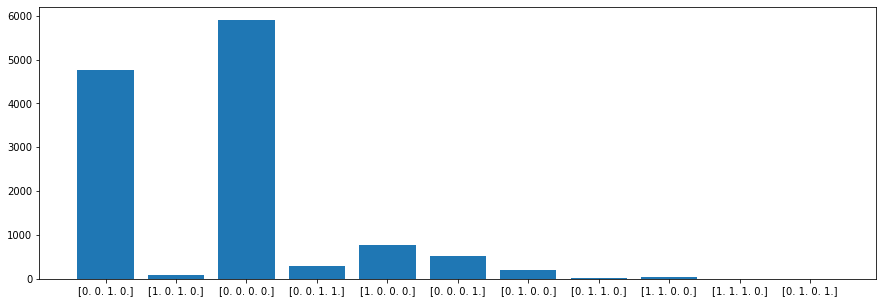

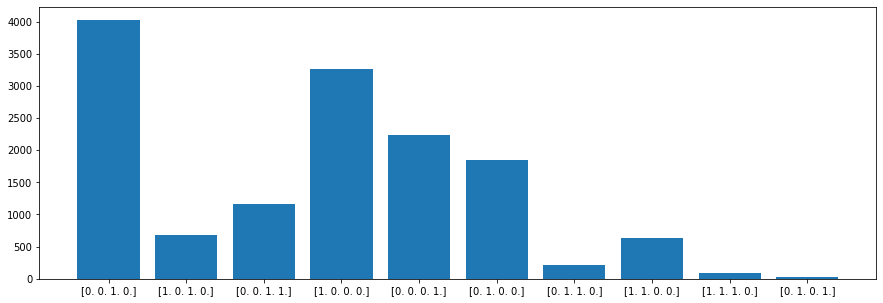

In [ ]:
# plot resampled distribution

y_counts_old = file_df[[1,2,3,4]].to_numpy()

counts = Counter(str(l) for l in y_counts_old)
plt.figure(figsize=(15, 5))
plt.bar(*zip(*counts.items()))
plt.show()

y_counts_new = df_train[[1,2,3,4]].to_numpy()

counts = Counter(str(l) for l in y_counts_new)
plt.figure(figsize=(15, 5))
plt.bar(*zip(*counts.items()))
plt.show()

In [ ]:
datagen=ImageDataGenerator(rescale=1./255., shear_range=20.0,
                           rotation_range=10, width_shift_range=0.2, height_shift_range=0.2,
                           horizontal_flip=True, vertical_flip=True, validation_split=0.15)

test_datagen=ImageDataGenerator(rescale=1./255.)

train_generator=datagen.flow_from_dataframe(dataframe=df_train,
                directory='/Users/tf/severstal-steel-defect-detection/train_images', subset="training",
                x_col='ImageId', y_col=[1,2,3,4],
                batch_size=64,
                seed=0, shuffle=True,
                class_mode='raw', color_mode="grayscale",
                target_size=(71,71))

valid_generator=datagen.flow_from_dataframe(dataframe=df_train,
                directory='/Users/tf/severstal-steel-defect-detection/train_images', subset="validation",
                x_col='ImageId', y_col=[1,2,3,4],
                batch_size=64,
                seed=0, shuffle=True,
                class_mode='raw', color_mode="grayscale",
                target_size=(71,71))

test_generator=test_datagen.flow_from_dataframe(dataframe=df_test,
                directory='/Users/tf/severstal-steel-defect-detection/train_images',
                x_col='ImageId', y_col=[1,2,3,4],
                batch_size=64,
                seed=0, shuffle=True,
                class_mode='raw', color_mode="grayscale",
                target_size=(71,71))

Found 12042 validated image filenames.
Found 2124 validated image filenames.
Found 1885 validated image filenames.


In [ ]:
def model(output_dim=4, num_filters=8, filter_sizes=[(1,3),(3,3),(3,1)], dropout=0.2):

    model_input = Input(shape=(71,71,1))

    pooled_outputs = []
    for i in range(len(filter_sizes)):
        conv = Conv2D(num_filters, kernel_size=filter_sizes[i], padding='same', activation=LeakyReLU(alpha=0.05))(model_input)
        conv = MaxPooling2D(pool_size=(2,2))(conv)
        pooled_outputs.append(conv)
    merge = concatenate(pooled_outputs)
    
    x = Conv2D(16,(3,3),activation=LeakyReLU(alpha=0.05),padding='same')(merge)
    x = Conv2D(16,(3,3),activation=LeakyReLU(alpha=0.05),padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    
    x = Conv2D(32,(3,3),activation=LeakyReLU(alpha=0.05),padding='same')(x)
    x = Conv2D(32,(3,3),activation=LeakyReLU(alpha=0.05),padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2))(x)

    x = Conv2D(24,(1,1),activation=LeakyReLU(alpha=0.05))(x)
    x = BatchNormalization()(x)
    
    flat = Flatten()(x)
    
    dense = Dropout(dropout)(flat)
    dense = Dense(50,activation=LeakyReLU(alpha=0.05))(dense)
    dense = Dropout(dropout)(dense)
    dense = Dense(24,activation=LeakyReLU(alpha=0.05))(dense)
    dense = Dropout(dropout)(dense)
    dense = Dense(24,activation=LeakyReLU(alpha=0.05))(dense)
    dense = Dropout(dropout)(dense)
    predictions = Dense(4,activation="sigmoid")(dense)
    
    model = Model(inputs=model_input,outputs=predictions)

    lr_schedule = schedules.ExponentialDecay(
        initial_learning_rate=0.0001,
        decay_steps=564,
        decay_rate=0.6)
    opt = optimizers.Adam(learning_rate=lr_schedule)
    
    model.compile(loss = 'binary_crossentropy', optimizer=opt, metrics=["accuracy",'binary_accuracy'])
    print(model.summary())
    
    return model

model = model()

Model: "model_51"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_54 (InputLayer)          [(None, 71, 71, 1)]  0           []                               
                                                                                                  
 conv2d_430 (Conv2D)            (None, 71, 71, 8)    32          ['input_54[0][0]']               
                                                                                                  
 conv2d_431 (Conv2D)            (None, 71, 71, 8)    80          ['input_54[0][0]']               
                                                                                                  
 conv2d_432 (Conv2D)            (None, 71, 71, 8)    32          ['input_54[0][0]']               
                                                                                           

In [ ]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
print(STEP_SIZE_TRAIN)
print(STEP_SIZE_VALID)
print(STEP_SIZE_TEST)

188
33
29


In [ ]:
callback_list = [
    tf.keras.callbacks.EarlyStopping(patience=2),
    tf.keras.callbacks.ModelCheckpoint(filepath='./[model2]-{epoch:02d}-{val_loss:.3f}.h5'),
]

history = model.fit(x=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=25,
                    callbacks=callback_list,
                    verbose=1)

Epoch 1/25
188/188 [==============================] - 95s 473ms/step - loss: 0.6736 - accuracy: 0.3189 - binary_accuracy: 0.5853 - val_loss: 0.6943 - val_accuracy: 0.1454 - val_binary_accuracy: 0.4782
Epoch 2/25
188/188 [==============================] - 102s 542ms/step - loss: 0.5925 - accuracy: 0.3649 - binary_accuracy: 0.6763 - val_loss: 0.6509 - val_accuracy: 0.3674 - val_binary_accuracy: 0.5868
Epoch 3/25
188/188 [==============================] - 113s 598ms/step - loss: 0.5651 - accuracy: 0.3825 - binary_accuracy: 0.6928 - val_loss: 0.5691 - val_accuracy: 0.4560 - val_binary_accuracy: 0.7156
Epoch 4/25
188/188 [==============================] - 115s 607ms/step - loss: 0.5499 - accuracy: 0.4051 - binary_accuracy: 0.7004 - val_loss: 0.5139 - val_accuracy: 0.4569 - val_binary_accuracy: 0.7307
Epoch 5/25
188/188 [==============================] - 116s 610ms/step - loss: 0.5380 - accuracy: 0.4133 - binary_accuracy: 0.7050 - val_loss: 0.5001 - val_accuracy: 0.4986 - val_binary_accuracy

### Results

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.index += 1

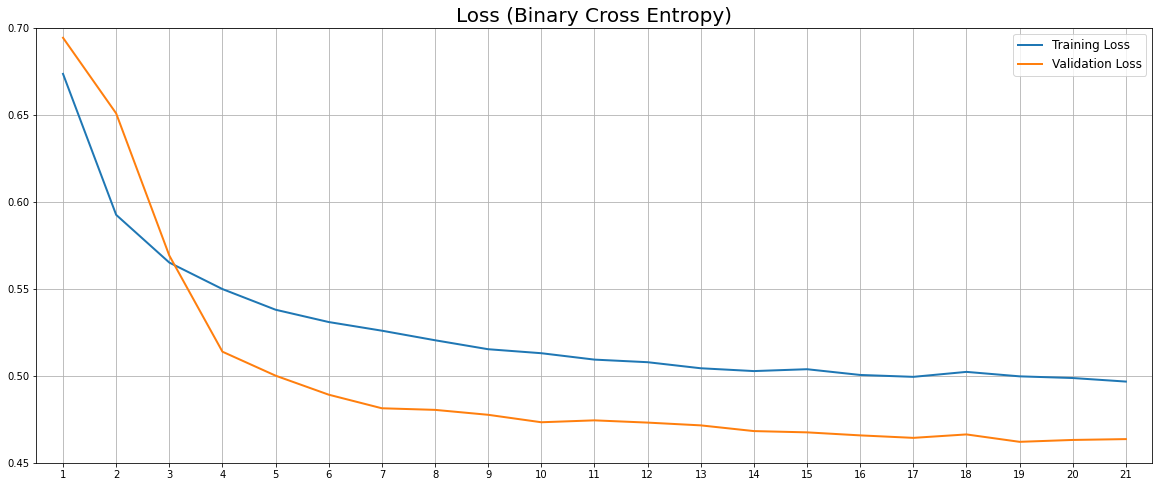

In [ ]:
plt.subplots(figsize=(20,8))
plt.plot(history_df.loc[:, ['loss','val_loss']], lw=2)
plt.title('Loss (Binary Cross Entropy)', fontsize=20)
plt.legend(['Training Loss','Validation Loss'], fontsize=12, loc=1)
plt.xlim(0.5,21.5)
plt.ylim(0.45,0.7)
plt.xticks(np.arange(1, 22, step=1))
plt.yticks(np.arange(0.45, 0.75, step=0.05))
plt.grid()
plt.show()

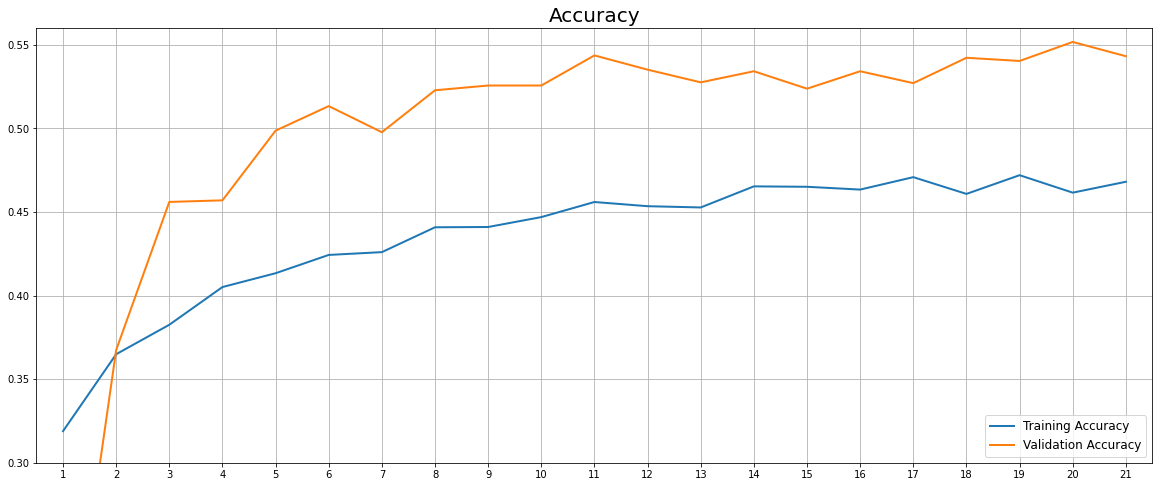

In [ ]:
plt.subplots(figsize=(20,8))
plt.plot(history_df.loc[:, ['accuracy','val_accuracy']], lw=2)
plt.title('Accuracy', fontsize=20)
plt.legend(['Training Accuracy','Validation Accuracy'], fontsize=12, loc=4)
plt.xlim(0.5,21.5)
plt.ylim(0.3,0.56)
plt.xticks(np.arange(1, 22, step=1))
plt.yticks(np.arange(0.3, 0.6, step=0.05))
plt.grid()
plt.show()

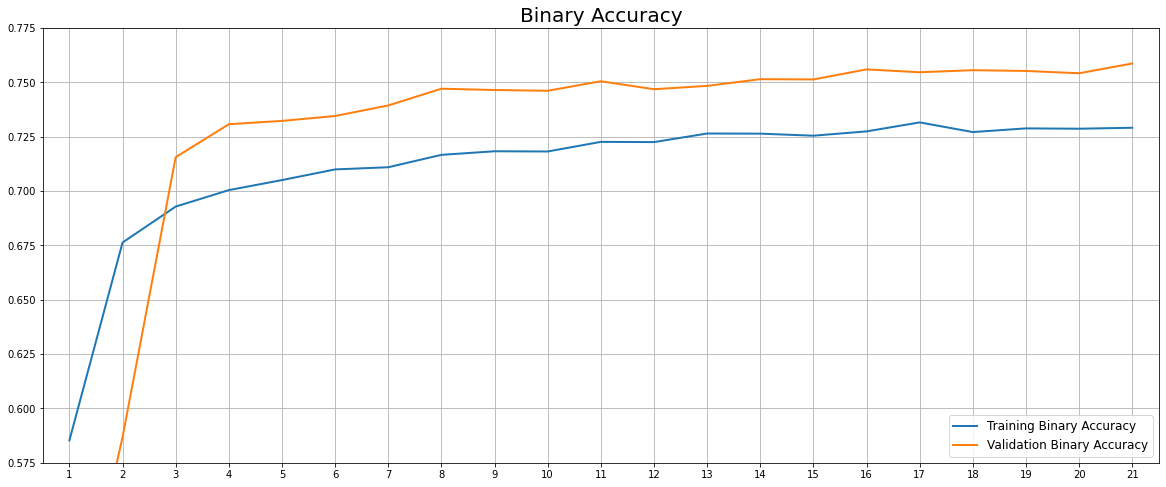

In [ ]:
plt.subplots(figsize=(20,8))
plt.plot(history_df.loc[:, ['binary_accuracy','val_binary_accuracy']], lw=2)
plt.title('Binary Accuracy', fontsize=20)
plt.legend(['Training Binary Accuracy','Validation Binary Accuracy'], fontsize=12, loc=4)
plt.xlim(0.5,21.5)
plt.ylim(0.575,0.775)
plt.xticks(np.arange(1, 22, step=1))
plt.yticks(np.arange(0.575, 0.775, step=0.025))
plt.grid()
plt.show()

In [ ]:
from keras.models import load_model
saved_model = load_model('/Users/tf/Desktop/[model3]-11-0.472.h5')

In [ ]:
y_eval = saved_model.evaluate(valid_generator)
valid_generator.reset()

y_pred = saved_model.predict(valid_generator, verbose=1)
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0
y_pred = pd.DataFrame(y_pred)

y_test = df_train.loc[valid_generator.index_array]

34/34 [==============================] - 9s 250ms/step


In [ ]:
print(y_eval)

[0.46312275528907776, 0.5414312481880188, 0.7583568692207336]


In [ ]:
tns, fps, fns, tps = [],[],[],[]

for i in range(4):
    tn, fp, fn, tp = confusion_matrix(list(y_test[i+1]), list(y_pred[i])).ravel()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    
    tns.append(tn)
    fps.append(fp)
    fns.append(fn)
    tps.append(tp)
    print(f'Metrics for Defect {i+1}:')
    print(np.array([[tn, fp],[fn, tp]]))
    print(f'F1       : {2*(precision*recall)/(precision+recall):0.3f}')
    print(f'Recall   : {recall:0.3f}')
    print(f'Precision: {precision:0.3f}')
    print('')
    
precision = sum(tps)/(sum(tps)+sum(fps))
recall = sum(tps)/(sum(tps)+sum(fns))
print('Overall Metrics:')
print(np.array([[sum(tns), sum(fps)],[sum(fns), sum(tps)]]))
print(f'F1       : {2*(precision*recall)/(precision+recall):0.3f}')
print(f'Recall   : {recall:0.3f}')
print(f'Precision: {precision:0.3f}')

Metrics for Defect 1:
[[1119  351]
 [ 508  146]]
F1       : 0.254
Recall   : 0.223
Precision: 0.294

Metrics for Defect 2:
[[1538  170]
 [ 377   39]]
F1       : 0.125
Recall   : 0.094
Precision: 0.187

Metrics for Defect 3:
[[650 524]
 [526 424]]
F1       : 0.447
Recall   : 0.446
Precision: 0.447

Metrics for Defect 4:
[[1125  404]
 [ 426  169]]
F1       : 0.289
Recall   : 0.284
Precision: 0.295

Overall Metrics:
[[4432 1449]
 [1837  778]]
F1       : 0.321
Recall   : 0.298
Precision: 0.349
